# Narrowband Energy Detection from Wideband Signal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from scipy import signal
import seaborn as sns
sns.set()

In [2]:
# Signal Generator Parameters:
freq = 3000.0 # Hz
duration = 10.0 # seconds
oversamp = 10 # oversampling rate
Fs = freq*oversamp # samples per second
AWGN_SNR = 0.0 # dB

NOTE: **Additive White Gaussian Noise (AWGN)** is sampled from a normal distribution with ${\mu} = 0$ and ${\sigma}^2 = 10^\frac{-SNR}{10}$ ([ref](https://www.sharetechnote.com/html/Handbook_Communication_awgn.html))

In [3]:
def sig_gen(freq, duration, Fs, AWGN_SNR=None, complex=False):
    '''
    Synthesizes a sinusoidal signal (with optional noise)
    
    freq = sinusoid frequency (in Hz)
    duration = duration of synthesized signal (in seconds)
    Fs = sample frequency (in samples per second)
    AWGN_SNR = signal-to-noise ratio for gaussian noise (in dB)
    complex = return complex samples? (boolean)
    '''
    if freq is None: # no tone present, just noise
        sig = 0.0
        freq = 0.0
    else:
        sig = 1.0
        
    omega = 2*np.pi*freq
    t = np.linspace(0,duration, int(duration*Fs))
    
    if AWGN_SNR is not None:
        # Additive White Gaussian Noise
        # Create gaussian white noise signal:
        awgn = np.random.normal(0, np.sqrt(np.power(10,-AWGN_SNR/10)), int(duration*Fs))
        if complex:
            awgn = np.random.normal(0, np.sqrt(np.power(10,-AWGN_SNR/10)), int(duration*Fs)) + \
                   1j*np.random.normal(0, np.sqrt(np.power(10,-AWGN_SNR/10)), int(duration*Fs))
            return sig*np.exp(-1j*(omega*t)) + awgn
        else:
            awgn = np.random.normal(0, np.sqrt(np.power(10,-AWGN_SNR/10)), int(duration*Fs))
            return sig*np.real(np.exp(-1j*(omega*t))) + awgn

In [4]:
def psd_plot(signal, NFFT=1024, width=16, freq_range=None, Fs=None):
    if NFFT%2 != 0:
        NFFT = NFFT+1
    i=0
    if len(signal)%NFFT != 0:
        signal = signal[:-(len(signal)%NFFT)] # discard extra data that can't be used
    output = np.zeros(int(len(signal)))
    while i < len(signal):
        output[i:i+NFFT] = np.absolute(np.fft.fft(signal[i:i+NFFT]))
        i += NFFT
    fft_data = output.reshape((int(np.floor(len(output)/NFFT)), NFFT))
    # square the values:
    squared = np.square(fft_data)
    # normalize by highest value in each fft, compute in dB:
    normalized_db = 10*np.log10(squared/np.amax(squared))
    # plot:
    if fft_data.shape[0]*16//300 == 0.0:
        assert False, "Not enough data to plot! Try inputting a longer signal."
    fig, ax = plt.subplots(figsize=(width, fft_data.shape[0]*16//300))
    ax.grid(False)
    
    #ax.matshow(np.flip(normalized_db[:,int(NFFT/2):], axis=1)) #shows half the plot
    ax.matshow(np.flip(normalized_db[:,:int(NFFT)], axis=1)) #shows full length of plot
    
    #to compute the frequencies the value of the samples per second is needed (Fs)
    if freq_range != None:
        x_ax_current = range(0, int(NFFT), 1)
        x_ax_scale = Fs/NFFT
        x_ticks_freq = ticker.FuncFormatter(lambda x_ax_current, pos: '{0:g}'.format(round(x_ax_current*x_ax_scale/1000,1)))            
        ax.xaxis.set_major_formatter(x_ticks_freq)
        ax.set(xlabel='Frequency (kHz)')
        
        #altered ticks such that there are more reference points
        ax.set_xticks(list(range(0, int(NFFT), 32))) 
        
    if Fs != None:
        y_ax_current = range(0, int(Fs))
        y_ax_scale = 30
        y_ticks_freq = ticker.FuncFormatter(lambda y_ax_current, pos: '{0:g}'.format(round(y_ax_current/y_ax_scale,2)))
        ax.yaxis.set_major_formatter(y_ticks_freq)
        ax.set(ylabel='Time (s)')
        #ax.set_yticks(list(range(0, int(Fs/y_ax_scale),100))) 
       
    return fig, ax

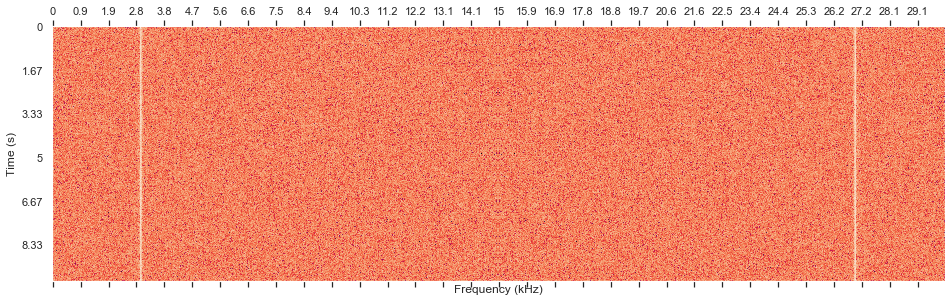

In [5]:
my_signal = sig_gen(freq, duration, Fs, AWGN_SNR=-10.0, complex=False)
temp = psd_plot(my_signal, freq_range=[2600, 3400], Fs=Fs)

In [6]:
# Create and on-off-keying (OOK) signal:
freq = 3000.0
Fs = 10*freq
AWGN_SNR = 0.0

noise_duration = 0.5
burst_duration = 0.25

my_signal2 = np.concatenate([sig_gen(None, 3*noise_duration, Fs, AWGN_SNR),
                            sig_gen(freq, burst_duration, Fs, AWGN_SNR),
                            sig_gen(None, noise_duration, Fs, AWGN_SNR),
                            sig_gen(freq, burst_duration, Fs, AWGN_SNR),
                            sig_gen(None, noise_duration, Fs, AWGN_SNR),
                            sig_gen(freq, burst_duration, Fs, AWGN_SNR),
                            sig_gen(None, 3*noise_duration, Fs, AWGN_SNR)])

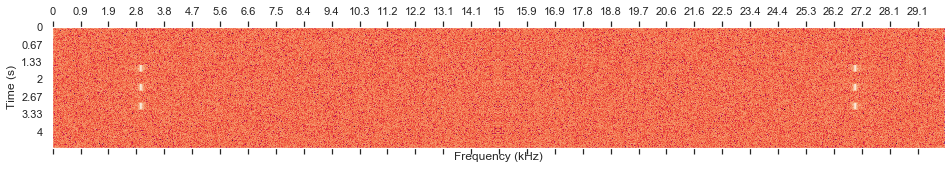

In [7]:
temp = psd_plot(my_signal2, freq_range=[2600, 3400], Fs=Fs)

In [8]:
def compare_threshold(window, threshold, scale_factor):
    '''
    returns a list of NB energy detections within the given signal window, based on the threshold given
    
    '''
    # Computes FFT of the given signal window
    window_fft = np.fft.fft(window, len(window))
    window_fft_normalized = (1/np.argmax(np.abs(window_fft))) * np.abs(window_fft) #Normalized to the peak value
    window_freq_fft = np.fft.fftfreq(len(window_fft))

    # Determines which (if any) FFT coefficients' magnitude exceeds threshold
    threshold = np.average(window_fft_normalized) + 2.33 * np.std(window_fft_normalized)
    threshold_comparison = np.average(window_fft_normalized) * scale_factor
    
    #comparison allows for user adjustment to mitigate false positives
    if threshold >= threshold_comparison:
        values_exceeding_thresh = window_fft_normalized > threshold
    else:
        values_exceeding_thresh = window_fft_normalized > threshold_comparison
        
    bins_exceeding_threshold = abs(window_freq_fft[values_exceeding_thresh])
 
    # Returns a list of FFT bins exceeding energy threshold within a certian freq range
    return bins_exceeding_threshold, threshold

In [9]:
def multiple_signal_detection(bins_up, num_stored, window_size, k, 
                              past_total_freqs=set(), past_freqs=set(), round_freq=-3):
    '''
    Uses the detected signals that are above a given threshold to determine when each of these signals is on or off
    
    bins_up = a list of tuples which contain the frequency and index of each bin exceeding the threshold
    returned = bool value which determines if there were any values that exceeded the threshold
    num_stored = the current index value for the window
    past_freqs = the current list of frequencies that are within wideband
    past_total_freqs = the current list of frequencies that are/were present
    ''' 
    temp_freqs = set()
    for i in bins_up:
        if i[0] == (k):
            temp_freqs.add(round(i[1],round_freq)) #stores and rounds value, default is to nearest 1000   
            
    for freq in temp_freqs:
        if (freq not in past_total_freqs) or (freq not in past_freqs): 
            print(f'{round(freq/1000,1)} kHz UP @ {round(k/(30*(1024/window_size)),2)} seconds')
            
    for freq in past_total_freqs:
        if freq not in temp_freqs:
            print(f'{round(freq/1000,1)} kHz DOWN @ {round(k/(30*(1024/window_size)),2)} seconds')
            
    past_freqs.clear()
    past_freqs = temp_freqs.copy()
    past_total_freqs = past_total_freqs.union(temp_freqs)
   
    return past_freqs, past_total_freqs

In [10]:
def run_energy_detection(signal, window_size=1024, freq_range = [0, 15000], Fs=30000, scale_factor=4):
    '''
    runs energy detection routine on the wideband signal given
    Signal = input signal to be checked
    window_size = size of the window
    freq_range = list containing two frequencies that the signal should lie within
    Fs = sample frequency
    scale_factor = threshold detection scale to mitigate false positives
    
    '''
    bins_up = []
    i, k, num_stored = 0, 0, 0
    threshold = 0
    sig_on = 0
    past_total_freqs = set()
    past_freqs = set()
    # Window size can be addjusted as an argument
    
    if len(signal)%window_size != 0:
        signal = signal[:-(len(signal)%window_size)] # discard extra data that can't be used
        
    # loops through each window, returning the time it was up and at what frequency
    while i < len(signal):
        bins_exceeding, threshold = compare_threshold(signal[i:i+window_size], threshold, scale_factor)
        returned = False
        
        #stores values that exceed threshold into a tuple
        for val in range(0,len(bins_exceeding)):
            if  freq_range[0] < (bins_exceeding[val]*Fs) < freq_range[1]:
                bins_up.append((k,round(bins_exceeding[val]*Fs)))
                num_stored += 1
                returned = True #alerts if there were signals added
        #determines up and down times for multiple signals        
        if returned:
            past_freqs, past_total_freqs = multiple_signal_detection(bins_up, num_stored, window_size, 
                                                                     k, past_total_freqs, past_freqs)
            sig_on = 1
        else:
            if sig_on == 1:
                for freq in past_freqs:
                    print(f'{round(freq/1000,1)} kHz DOWN @ {round(k/(30*(1024/window_size)),2)} seconds')
                sig_on = 0
                past_freqs.clear()
        k += 1
        i += window_size
        
    #Prints final result of the signal if it remains on through the entire duration    
    if sig_on:
        print(f'{round(bins_up[num_stored-1][1],-3)/1000} kHz finished UP @ {round(k/(30*(1024/window_size)),2)} seconds')        
    # returns list of tuples that contain up/down times at certain frequency
    return bins_up

In [11]:
signal1_test = run_energy_detection(my_signal, window_size=1024, freq_range=[2600, 3400], Fs=Fs, scale_factor = 2)

3.0 kHz UP @ 0.0 seconds
3.0 kHz finished UP @ 9.73 seconds


In [12]:
signal2_test = run_energy_detection(my_signal2, window_size=512, freq_range=[2600,3400], Fs=Fs, scale_factor = 4)

3.0 kHz UP @ 1.47 seconds
3.0 kHz DOWN @ 1.72 seconds
3.0 kHz UP @ 2.2 seconds
3.0 kHz DOWN @ 2.45 seconds
3.0 kHz UP @ 2.93 seconds
3.0 kHz DOWN @ 3.18 seconds


C:\Users\Ben\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in longlong_scalars
  
C:\Users\Ben\anaconda3\lib\site-packages\numpy\core\_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Note: 
* Sometimes the signal will return a frequency that is close to or near the desired frequency, can be off by at most 200Hz.
  The values shown are rounded, so they normally represent a value off by 10 or so Hz.
* The graphs will adjust to a larger frequency range due to the increasing samples/sec, Fs. Currently, the y-axis is not adjusted to display more tick marks as that also would change when looking at higher samples/sec values.
    * Additionally, since the axis' are dependent on the number of bins and samples/sec, it seems very difficult to obtain tick numbers that are 'visually pleasing' (whole numbers).
* I'm also not too sure the impact of the 'second' data line show in the graph. The code outputs the first occurance that beats the threshold to minimize repeated values. So, if the second data line is a copy of the first then it would output a similar frequency. 
* Fixed functionality for multiple signal inputs